# What's Cooking ?

In [1]:
# Librairies 
import os
import pandas as pd
import numpy as np
from scipy import stats as scs
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import random
import re
from time import time

pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', 60)

## Load & check data

In [2]:
df_train = pd.read_json('train.json')
df_test = pd.read_json('test.json')

In [3]:
df_train.head()

,cuisine,id,ingredients
0,greek,10259,"[romaine lettuce, black olives, grape tomatoes..."
1,southern_us,25693,"[plain flour, ground pepper, salt, tomatoes, g..."
2,filipino,20130,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,indian,22213,"[water, vegetable oil, wheat, salt]"
4,indian,13162,"[black pepper, shallots, cornflour, cayenne pe..."


In [4]:
print('Dimension train set : ', df_train.shape)
print('Dimension test set : ', df_test.shape)

Dimension train set :  (39774, 3)
Dimension test set :  (9944, 2)


In [5]:
print('Number of unique id : ', len(df_train['id'].unique()))
print('Number of unique cuisine type :', len(df_train['cuisine'].unique()))

Number of unique id :  39774
Number of unique cuisine type : 20


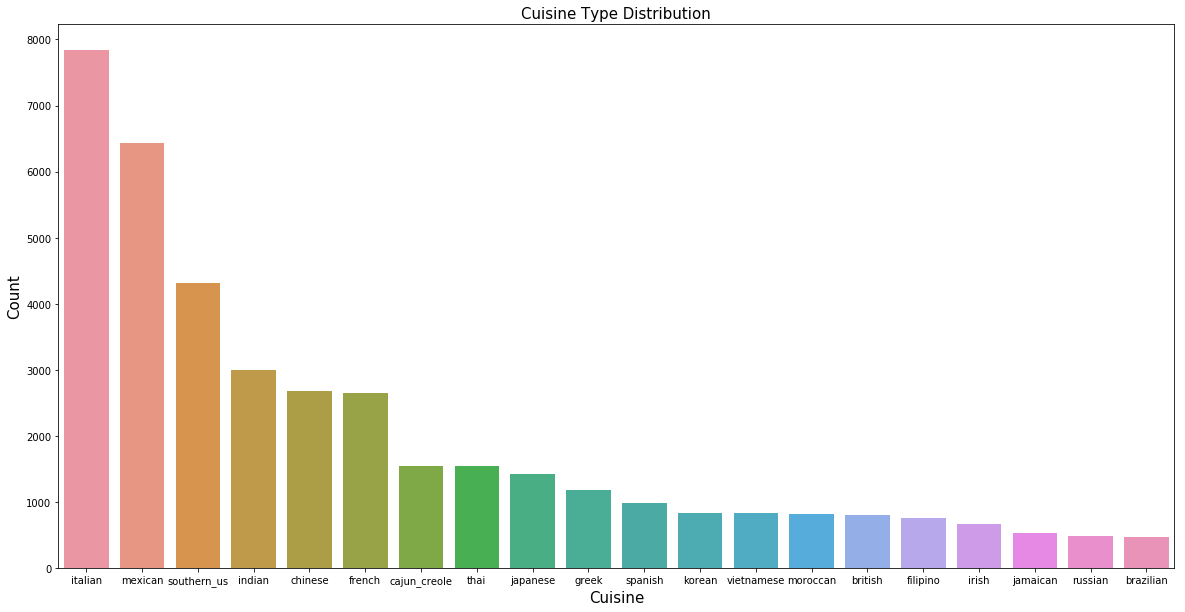

In [6]:
# Check distribution of cuisine type
plt.figure(figsize=(20,10))
ax = sns.countplot(df_train['cuisine'], order=df_train['cuisine'].value_counts().index)
ax.set_title('Cuisine Type Distribution', fontsize=15)
ax.set_xlabel('Cuisine', fontsize=15)
ax.set_ylabel('Count', fontsize=15)
plt.show()

As we can see, the dataset is quite unbalanced with 6 dominant categories that are Italian, Mexican, South America, Indian, Chinese and French cuisine.  
For the rest, the categories are pretty well balanced.

Before starting with the preprocessing step, let's see if some words can determine some categories.

In [7]:
# Join ingredients into one string
df_train['join'] = df_train['ingredients'].apply(lambda x: ' '.join(x)) 

In [8]:
# Plot distribution of cuisine type with specific ingredient
def distribution_specific_ingredient(df, col, ingredient):
    
    plt.figure(figsize=(19,6))
    ax = sns.countplot(df[col], order=df.cuisine.value_counts().index)
    ax.set_title('Cuisine Type with %s' %ingredient, fontsize=15)
    ax.set_xlabel('Cuisine', fontsize=15)
    ax.set_ylabel('Count', fontsize=15)
    plt.show()

    print("%s data have %s in their ingredients" % (df.shape[0], ingredient))

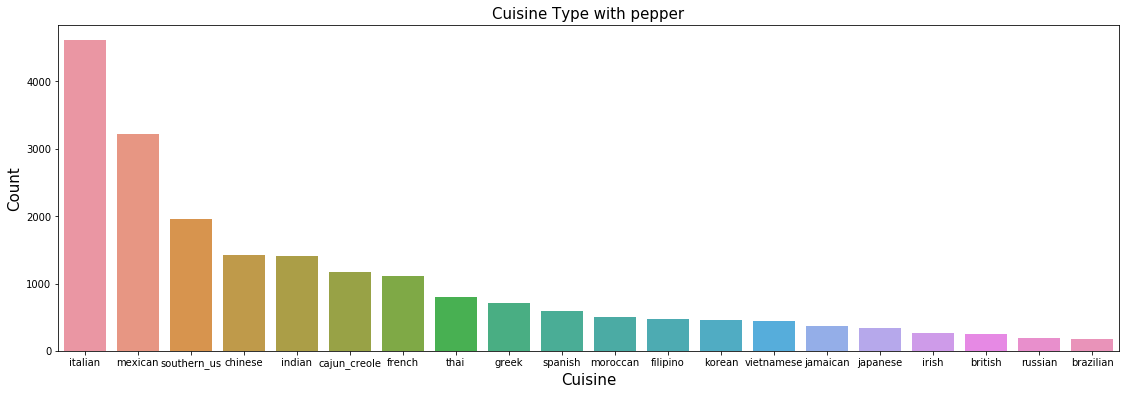

20498 data have pepper in their ingredients


In [9]:
# Let's see data containing some words
df = df_train[df_train['join'].str.contains('pepper')]
distribution_specific_ingredient(df, 'cuisine', 'pepper')

As we can see, 50% of the training data have pepper in their ingredients.  
The distribution per cuisine type is similar to the previous distribution, we can interpret this by the fact that "pepper" is a common ingredient for each cuisine type.

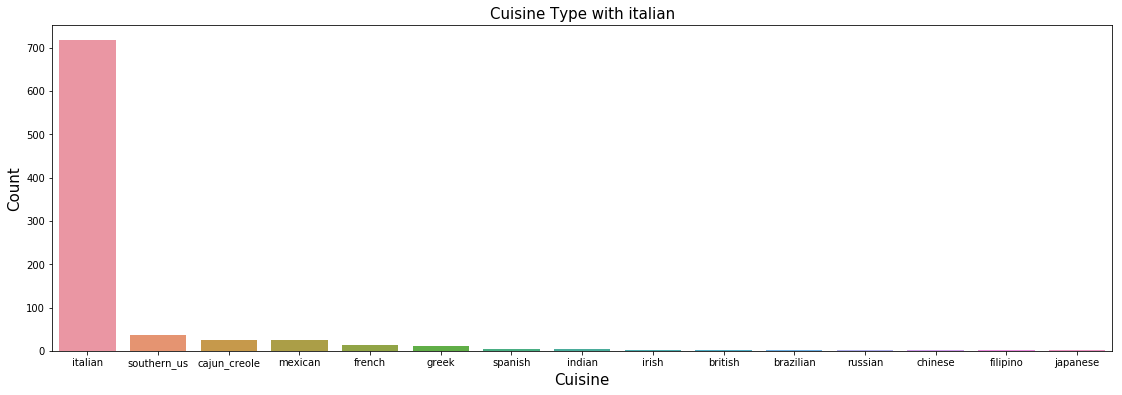

846 data have italian in their ingredients


In [10]:
# Let's see data containing some words
df_italian = df_train[df_train['join'].str.contains('italian')]
distribution_specific_ingredient(df_italian, 'cuisine', 'italian')

As we can see most of the data containing "italian" in the ingredients are Italian type.  
10 % of training data of Italian type have the word "italian" in their ingredients.

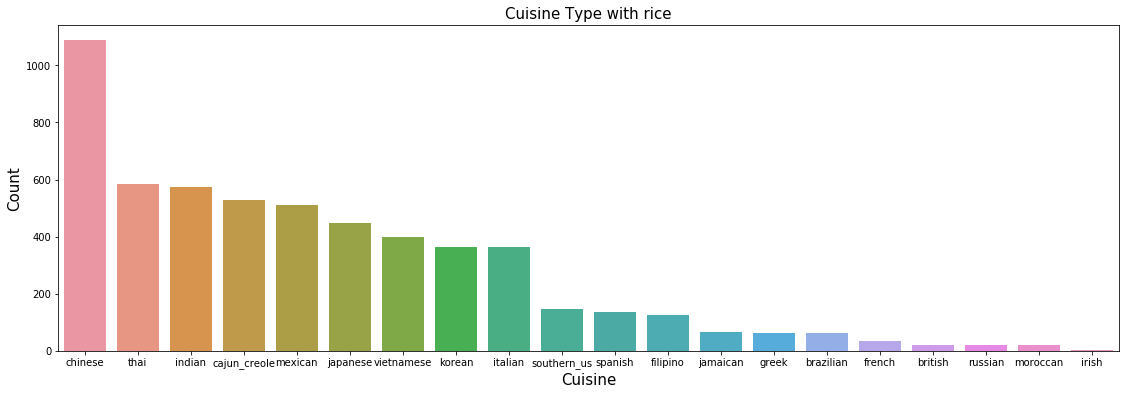

5554 data have rice in their ingredients


In [11]:
df_rice = df_train[df_train['join'].str.contains('rice')]
distribution_specific_ingredient(df_rice, 'cuisine', 'rice')

As we can see most of the data containing "rice" in the ingredients are asian type of cuisine.

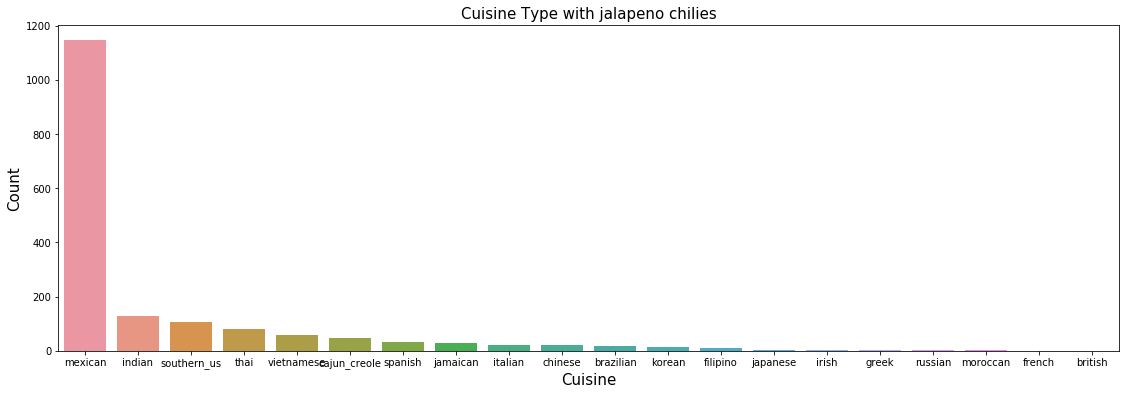

1730 data have jalapeno chilies in their ingredients


In [12]:
df_jalapeno_chilies = df_train[df_train['join'].str.contains('jalapeno chilies')]
distribution_specific_ingredient(df_jalapeno_chilies, 'cuisine', 'jalapeno chilies')

As we can see most of the data containing "jalapeno chilies" in the ingredients are south american / hispanic cuisine type.

Conclusion : Some ingredients are general and some are determinant for cuisine type

## Preprocessing

In [13]:
# Function for preprocessing
def preprocessing(df, name_col):
    df[name_col+"_formatted"] = df[name_col].apply(lambda x: [re.sub(r"\d", "", ingredient) for ingredient in x])
    df[name_col + "_formatted"] = df[name_col + "_formatted"].apply(lambda x: [re.sub(r"[()\.-]", "", ingredient) for ingredient in x])
    df[name_col + "_formatted"] = df[name_col + "_formatted"].apply(lambda x: [re.sub(r"KRAFT", "", ingredient) for ingredient in x])
    df[name_col + "_formatted"] = df[name_col + "_formatted"].apply(lambda x: [re.sub(r"\b[a-z]{,2}\b", "", ingredient) for ingredient in x])
    df[name_col + "_formatted"] = df[name_col + "_formatted"].apply(lambda x: [re.sub(r"\s+", "", ingredient) for ingredient in x])
    df[name_col + "_formatted"] = df[name_col + "_formatted"].apply(lambda x: [ingredient.lower() for ingredient in x])
    return df

In [14]:
df_train = preprocessing(df_train, "ingredients")
df_train.head()

,cuisine,id,ingredients,join,ingredients_formatted
0,greek,10259,"[romaine lettuce, black olives, grape tomatoes...",romaine lettuce black olives grape tomatoes ga...,"[romainelettuce, blackolives, grapetomatoes, g..."
1,southern_us,25693,"[plain flour, ground pepper, salt, tomatoes, g...",plain flour ground pepper salt tomatoes ground...,"[plainflour, groundpepper, salt, tomatoes, gro..."
2,filipino,20130,"[eggs, pepper, salt, mayonaise, cooking oil, g...",eggs pepper salt mayonaise cooking oil green c...,"[eggs, pepper, salt, mayonaise, cookingoil, gr..."
3,indian,22213,"[water, vegetable oil, wheat, salt]",water vegetable oil wheat salt,"[water, vegetableoil, wheat, salt]"
4,indian,13162,"[black pepper, shallots, cornflour, cayenne pe...",black pepper shallots cornflour cayenne pepper...,"[blackpepper, shallots, cornflour, cayennepepp..."


In [15]:
df_test = preprocessing(df_test, "ingredients")
df_test.head()

,id,ingredients,ingredients_formatted
0,18009,"[baking powder, eggs, all-purpose flour, raisi...","[bakingpowder, eggs, allpurposeflour, raisins,..."
1,28583,"[sugar, egg yolks, corn starch, cream of tarta...","[sugar, eggyolks, cornstarch, creamtartar, ban..."
2,41580,"[sausage links, fennel bulb, fronds, olive oil...","[sausagelinks, fennelbulb, fronds, oliveoil, c..."
3,29752,"[meat cuts, file powder, smoked sausage, okra,...","[meatcuts, filepowder, smokedsausage, okra, sh..."
4,35687,"[ground black pepper, salt, sausage casings, l...","[groundblackpepper, salt, sausagecasings, leek..."


## Word Embedding

In [16]:
# Create documents
def generate_document(df):
    doc = []
    doc = list(df.apply(lambda x: ' '.join(x)))
    return doc

documents = generate_document(df_train['ingredients_formatted'])
documents_test = generate_document(df_test['ingredients_formatted'])

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Return train and test set in tfidf representation
def tfidf(doc, doc_test, max_feat):
    # create the transform
    tfidf = TfidfVectorizer(max_features = max_feat)
    
    # tokenize and build vocab
    tfidf.fit(documents)
    
    # transform doc train
    tfs = tfidf.fit_transform(doc)
    X = pd.DataFrame(tfs.toarray(), columns=tfidf.get_feature_names())
    
    # transform doc test
    tfs_test = tfidf.transform(doc_test)
    Xtest = pd.DataFrame(tfs_test.toarray(), columns=tfidf.get_feature_names())
    
    return X, Xtest

## Label Encoding

In [18]:
from sklearn.preprocessing import LabelEncoder

cuisine_type = pd.DataFrame()
lb_encoder = LabelEncoder()
cuisine_type['cuisine_type_label'] = lb_encoder.fit_transform(df_train["cuisine"])
cuisine_type['cuisine_type'] = lb_encoder.inverse_transform(cuisine_type['cuisine_type_label'])

y = pd.DataFrame(cuisine_type['cuisine_type_label'])

## Model

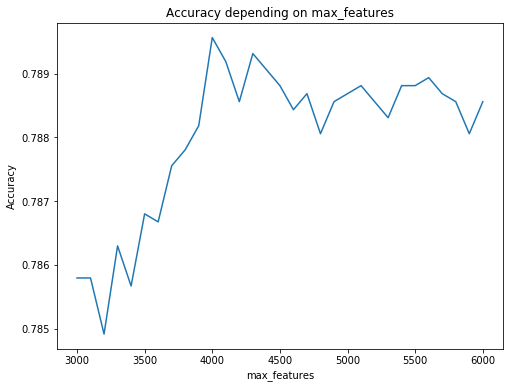

In [19]:
from sklearn.svm import LinearSVC

# Check which max_features is the best for the tfidf model
K = list(range(3000,6001, 100))
list_score = []

for max_feat in K:
    X, X_test = tfidf(documents, documents_test, max_feat)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=22)
    
    clf = LinearSVC(random_state=0, tol=1e-5, C=0.5)
    clf.fit(X_train, np.ravel(y_train))
    score = accuracy_score(clf.predict(X_test), np.ravel(y_test))
    list_score.append(score)
    
# Plot accuracy depending on parameter max_features    
plt.figure(figsize=(8,6))
plt.title('Accuracy depending on max_features')
plt.xlabel('max_features')
plt.ylabel('Accuracy')
plt.plot(K, list_score)
plt.show() 


In [20]:
max_feat = K[np.argmax(list_score)]
print(max_feat)

4000


In [21]:
X, Xtest = tfidf(documents, documents_test, 4000)

In [22]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score, cross_val_predict

# Cross validation

t1 = time()

model = LinearSVC(random_state=0, tol=1e-5, C=0.5)
scores = cross_val_score(model, X, np.ravel(y), cv=8)

print("Training done in %0.3fs" % (time() - t1))
print("Cross-validated scores", scores)
print("Mean :", np.mean(scores))

Training done in 57.982s
Cross-validated scores [0.78498294 0.79329048 0.79465541 0.79505229 0.78917723 0.77641377
 0.79854956 0.79584845]
Mean : 0.7909962649110254


In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=22)

In [25]:
# Train test split 

start_time = time()

model = LinearSVC(random_state=0, tol=1e-5, C=0.5)
model.fit(X_train, np.ravel(y_train))
score = accuracy_score(y_test, model.predict(X_test))

print("Training done in %0.3fs" % (time() - start_time))
print("Score : ", score)

Training done in 1.974s
Score :  0.789566310496543


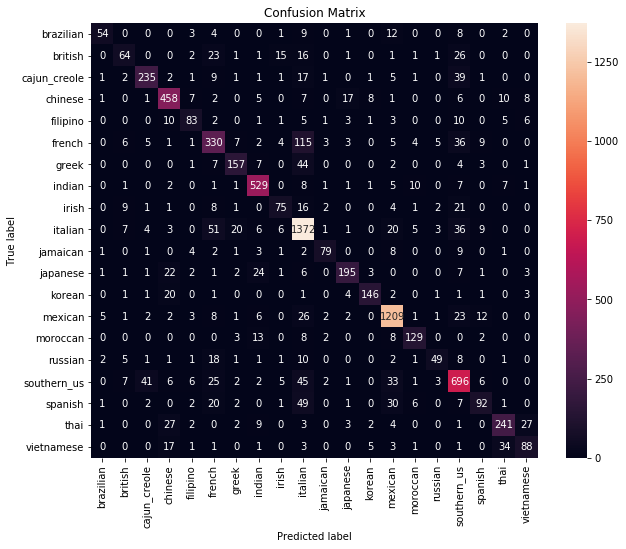

In [38]:
from sklearn.metrics import confusion_matrix

class_name = lb_encoder.inverse_transform(list(range(0,20)))

# Creates a confusion matrix
cm = confusion_matrix(y_test, model.predict(X_test)) 

# Transform to df for easier plotting
cm_df = pd.DataFrame(cm, index=class_name, columns=class_name)

plt.figure(figsize=(10,8))
sns.heatmap(cm_df, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Evaluation of the model :   

The cross validation and train test split give pretty similar accuracy score so the model doesn't seem to overfit.  
Since the dataset was quite unbalanced with 6 dominant categories that are Italian, Mexican, South America, Indian, Chinese and French cuisine, we can see on the confusion matrix that we have most of the good predictions on these categories.  
So the LinearSVC model is doing well even though the accuracy score isn't very high.

In [ ]:
# TEST SVC
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier

%%time

clf = SVC(C=300, kernel='rbf', degree=3,
          gamma=1, coef0=1, shrinking=True, 
          probability=False, tol=0.001, cache_size=1000,
          class_weight=None, verbose=True, max_iter=-1)
model = OneVsRestClassifier(clf, n_jobs=-1)
model.fit(X_train, np.ravel(y_train))

# Prediction

In [ ]:
model = LinearSVC(random_state=0, tol=1e-5, C=1)
model.fit(X, np.ravel(y))
y_pred = model.predict(Xtest)
y_pred = lb_encoder.inverse_transform(y_pred)

df_test['cuisine'] = y_pred
df_test[['id', 'cuisine']].head()

In [ ]:
df_test[['id', 'cuisine']].to_csv('submission2.csv', index=False)

Final prediction score : 0.78992

# Improvements

LinearSVC gives around 78-79% of accuracy.  
Advantage of this model is the running time but it's not the best classifier.  
I tried SVC with gaussian or rbf kernel since they give best result on Kaggle but the running time was too long so I couldn't train a model.  
I also tried some bagging methods like ExtraTrees, XGBoost but the running time was too long too.